In [28]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

# Load Weather Data

In [18]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    dir_weather = r'data/weather'
    weather_data_files = []
    for file in os.listdir(dir_weather):
        if file.endswith('.csv'):
            path = os.path.join(dir_weather,file)
            data = pd.read_csv(path,low_memory=False,header = None)
            weather_data_files.append(data)
    df = pd.concat(weather_data_files)
    #df.columns = pd.read_csv('data/weather/names.txt',header = None)

    col_names = pd.read_csv('data/weather/names.txt',low_memory=False,header = None).squeeze()

    df.columns = col_names
    
    date = []
    week = []

    for y,m,d,h in zip(df['Year'],df['Month'],df['Day'],df['Hour']):
        n = pd.Timestamp(year=y, month=m, day=d, hour=h)
        date.append(n)
        week.append(n.weekofyear)
    
    # create data and week column
    df['Date'] = pd.Series(date) 
    df['Week'] = pd.Series(week) 
    

    df.set_index(['Year', 'Month','Week','Day', 'Hour'],inplace = True)

    
    weather_data = df
    
    
    return weather_data

data_weather = load_weather_data()

In [19]:
data_weather.shape

(96432, 104)

In [20]:
# Counting combination of year+week that has the lowest number of entries
d2 = data_weather.swaplevel(1, 2)
sub_index_list = [(y,w) for y,w,m,d,h in d2.index.tolist()]
count = []
for y_w in np.unique(sub_index_list, axis = 0):
    count.append([y_w[0],y_w[1],len(d2.loc[(y_w[0],y_w[1]),:])])
count = np.array(count)
np.unique(count[:,2])

array([168, 192])

# Load Influenza Data

In [21]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    #nd.array
    def romanToarabic(col):
        n = []
        for s in col:
            if s == 'I.':
                n.append(1)
            elif s == 'II.':
                n.append(2)
            elif s == 'III.':
                n.append(3)
            elif s == 'IV.':
                n.append(4)
            elif s == 'V.':
                n.append(5)
            elif s == 'VI.':
                n.append(6)
            elif s == 'VII.':
                n.append(7)
            elif s == 'VIII.':
                n.append(8)
            elif s == 'IX.':
                n.append(9)
            elif s == 'X.':
                n.append(10)
            elif s == 'XI.':
                n.append(11)
            elif s == 'XII.':
                n.append(12)
        return pd.Series(n)
    
    dir_influenza = r'data/influenza'
    for f in os.listdir(dir_influenza):
        path = os.path.join(dir_influenza,f)
    data = pd.read_csv(path,low_memory=False)
    
    df_stacked = data.set_index('week').stack()
    df = pd.DataFrame(df_stacked).reset_index()
    df = df.rename(columns={"level_1": "Year", "week": "Week"})
    
    # custom number of splits
    df[['Week', 'Month']] = df['Week'].str.split('.', n=1, expand=True)
    df = df.T.drop_duplicates().T
    df['Month'] = romanToarabic(df['Month'])
    df["Year"] = df["Year"].str.replace('season', "")
    
    year = []
    for y,m in zip(df.Year,df.Month):
        lhs, rhs = y.split("/", 1)
        #year.append(lhs)
        if m>=9:
            year.append(lhs)
        elif m<=4:
            year.append(rhs)
     
    
    df["Year"] = year
    df["Year"] = df['Year'].str.strip(' ')
    df["Year"] = df["Year"].astype(int)
    df["Week"] = df["Week"].astype(int)
    influenza_data = df
    influenza_data.set_index(['Year','Week'],inplace = True)
    influenza_data.rename(columns={0:"Influenza_cases"},inplace = True)
    influenza_data = influenza_data.sort_index(level=0)
    
    return influenza_data

data_influenza = load_influenza_data()

# Handling Missing Values

In [22]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    
    df = incomplete_data
   
    # Remove rows with all NaN values
    complete_data = df.dropna(axis=0, how='all')

    # YOUR CODE HERE
    #raise NotImplementedError()
    return complete_data


def handle_missingValues_advanced(incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """

    df = incomplete_data
    
    # Air Temperature:
    df['Air Temperature [°C]'] = df['Air Temperature [°C]'].interpolate()
    # Surface pressure [hPa]
    df['Surface pressure [hPa]'] = df['Surface pressure [hPa]'].interpolate()
    # Mean sea-level pressure [hPa]
    df['Mean sea-level pressure [hPa]'] = df['Mean sea-level pressure [hPa]'].interpolate()
    
    # Relative humidity
    df['Relative humidity [%]'] = np.where(df['Wind direction  [°]'].between(258.75, 281.25, inclusive="both"), 
                                           np.nan, df['Relative humidity [%]'])
    df['Relative humidity [%]'] = df['Relative humidity [%]'].interpolate()
    
    
    ##### Measurement status
    
    # Implementation: if data in a column called Measurement status _X_ contains a specific code (either 8 or 9) 
    #then the preceding column value is not reliable.
    measurment_col = df.filter(regex='Measurement status').columns
    for col in df.filter(regex='Measurement status').columns:
        index_no = df.columns.get_loc(col)
        df.iloc[:,index_no-1] = np.where(df[col].between(8, 9, inclusive="both"), np.nan
                                                       , df.iloc[:,index_no-1])
        colname = df.columns[index_no-1]
        if (colname != 'Wind gust  [m/s]'):
            #df.iloc[:,index_no-1] = df.iloc[:,index_no-1].interpolate()
            df.loc[:,colname] = df.loc[:,colname].interpolate()
        else:
            df.loc[:,colname] = df.loc[:,'Wind speed  [m/s]']*1.55
            
    # Implementation: For the remaining columns, especially Measurement status _X_,
    # filling the missing values with 0
    for col in df.filter(regex='Measurement status').columns:     
        df[col] = df[col].fillna(0)
    
    
    zero_cols = [ col for col, is_zero in ((df == 0).sum() == df.shape[0]).items() if is_zero ]
    df.drop(zero_cols, axis=1, inplace=True)
    
    # Delete columns containing either 75% or more than 75% NaN Values
    perc = 70.0
    min_count =  int(((100-perc)/100)*df.shape[0] + 1)
    mod_df = df.dropna( axis=1, thresh=min_count)
    
    #complete_data = df
    complete_data = mod_df
    return complete_data
    
data_weather_complete = handle_missingValues_simple(data_weather)
data_weather_complete = handle_missingValues_advanced(data_weather_complete)


In [23]:
def missing_values_table(df):
        NaN_val = df.isnull().sum()
        NaN_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([NaN_val, NaN_percent], axis=1)
        mz_table = mz_table.rename(columns = {0 :'#NaN', 1 : '% NaN'})
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:,0] != 0].sort_values('% NaN', ascending=False)
        print ("Selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " rows.\n"      
            + str(mz_table.shape[0]) +
              " columns have NaN values.\n"
               + str(len(mz_table[mz_table.iloc[:,0] == df.shape[0]])) +
              " columns have all NaN values.\n")
        print('Displaying columns having NaN values')
        return mz_table

In [24]:
missing_values_table(data_weather_complete)

Selected dataframe has 83 columns and 96432 rows.
21 columns have NaN values.
0 columns have all NaN values.

Displaying columns having NaN values


,#NaN,% NaN,Data Type
0,,,
Occurrence of dew [0/1],45984,47.685416,float64
Clouds CM text,8762,9.086195,object
Cloud base height text [description],8761,9.085158,object
Clouds CH text,8760,9.084121,object
Clouds CL text,8760,9.084121,object
Wet-bulb temperature [°C],4498,4.664427,float64
Sample height [cm],1098,1.138626,float64
Snow water equivalent [mm/cm],1098,1.138626,float64
Sample weight [g],1098,1.138626,float64


# Handling Outliers

In [25]:
def handle_outliers(noisy_data):
    """
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    ## defining a function called 'outliers' which returns a list of indices of outliers
    def outlier_index(df):
        col = df['Air Temperature [°C]']
        Q1 = col.quantile(0.25)
        Q3 = col.quantile(0.75)
        IQR =  Q3-Q1

        lower_bound = (Q1-1.5*IQR)
        upper_bound = (Q3+1.5*IQR)

        ls = df.index[(col<lower_bound) | (col>upper_bound)]
        return ls
    
    def remove_outliers(df,outliers):
        df = df.drop(outliers)
        return df
    
    #  removing rows with outliers
    cleaned_data = remove_outliers(noisy_data,outlier_index(noisy_data))

    
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

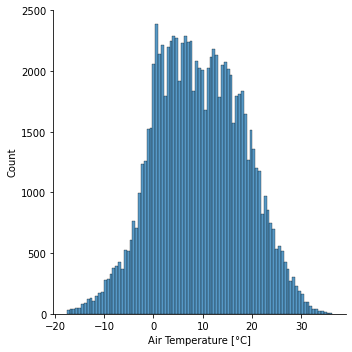

In [30]:
sns.displot(data=data_weather_cleaned, x='Air Temperature [°C]')
plt.show()

# Aggregate values¶

In [31]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()
    # YOUR CODE HERE
    #raise NotImplementedError()
    weekly_weather_data = pd.DataFrame()
    
    weekly_weather_data['temp_weeklyMin']=data_weather_cleaned.groupby(['Year','Week'])['Air Temperature [°C]'].min()
    weekly_weather_data['temp_weeklyMax']=data_weather_cleaned.groupby(['Year','Week'])['Air Temperature [°C]'].max()
    weekly_weather_data['temp_weeklyMean']=data_weather_cleaned.groupby(['Year','Week'])['Air Temperature [°C]'].mean()
    weekly_weather_data['temp_weeklyMedian']=data_weather_cleaned.groupby(['Year','Week'])['Air Temperature [°C]'].median()
    
    weekly_weather_data['precip_weeklyMin']=data_weather_cleaned.groupby(['Year','Week'])['Precipitation past 6 hours [mm]'].min()
    weekly_weather_data['precip_weeklyMax']=data_weather_cleaned.groupby(['Year','Week'])['Precipitation past 6 hours [mm]'].max()
    weekly_weather_data['precip_weeklyMean']=data_weather_cleaned.groupby(['Year','Week'])['Precipitation past 6 hours [mm]'].mean()

    
    weekly_weather_data['hum_weeklyMin']=data_weather_cleaned.groupby(['Year','Week'])['Relative humidity [%]'].min()
    weekly_weather_data['hum_weeklyMax']=data_weather_cleaned.groupby(['Year','Week'])['Relative humidity [%]'].max()
    weekly_weather_data['hum_weeklyMean']=data_weather_cleaned.groupby(['Year','Week'])['Relative humidity [%]'].mean()

    
    weekly_weather_data['gust_weeklyMax']=data_weather_cleaned.groupby(['Year','Week'])['Wind gust  [m/s]'].min()
    weekly_weather_data['wind_weeklyMax']=data_weather_cleaned.groupby(['Year','Week'])['Wind speed  [m/s]'].max()
    weekly_weather_data['wind_weeklyMean']=data_weather_cleaned.groupby(['Year','Week'])['Wind speed  [m/s]'].mean()


    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

# Merge influenza and weather datasets


In [39]:
def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    # YOUR CODE HERE
    #raise NotImplementedError()

    merged_data = weather_df.merge(influenza_df, left_index=True, right_index=True)
    
    # Remove rows with all NaN values
    merged_data = merged_data.dropna(axis= 'rows', how = 'any', subset=['hum_weeklyMean','Influenza_cases'] )

    
    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)


In [40]:
data_merged.shape

(336, 15)

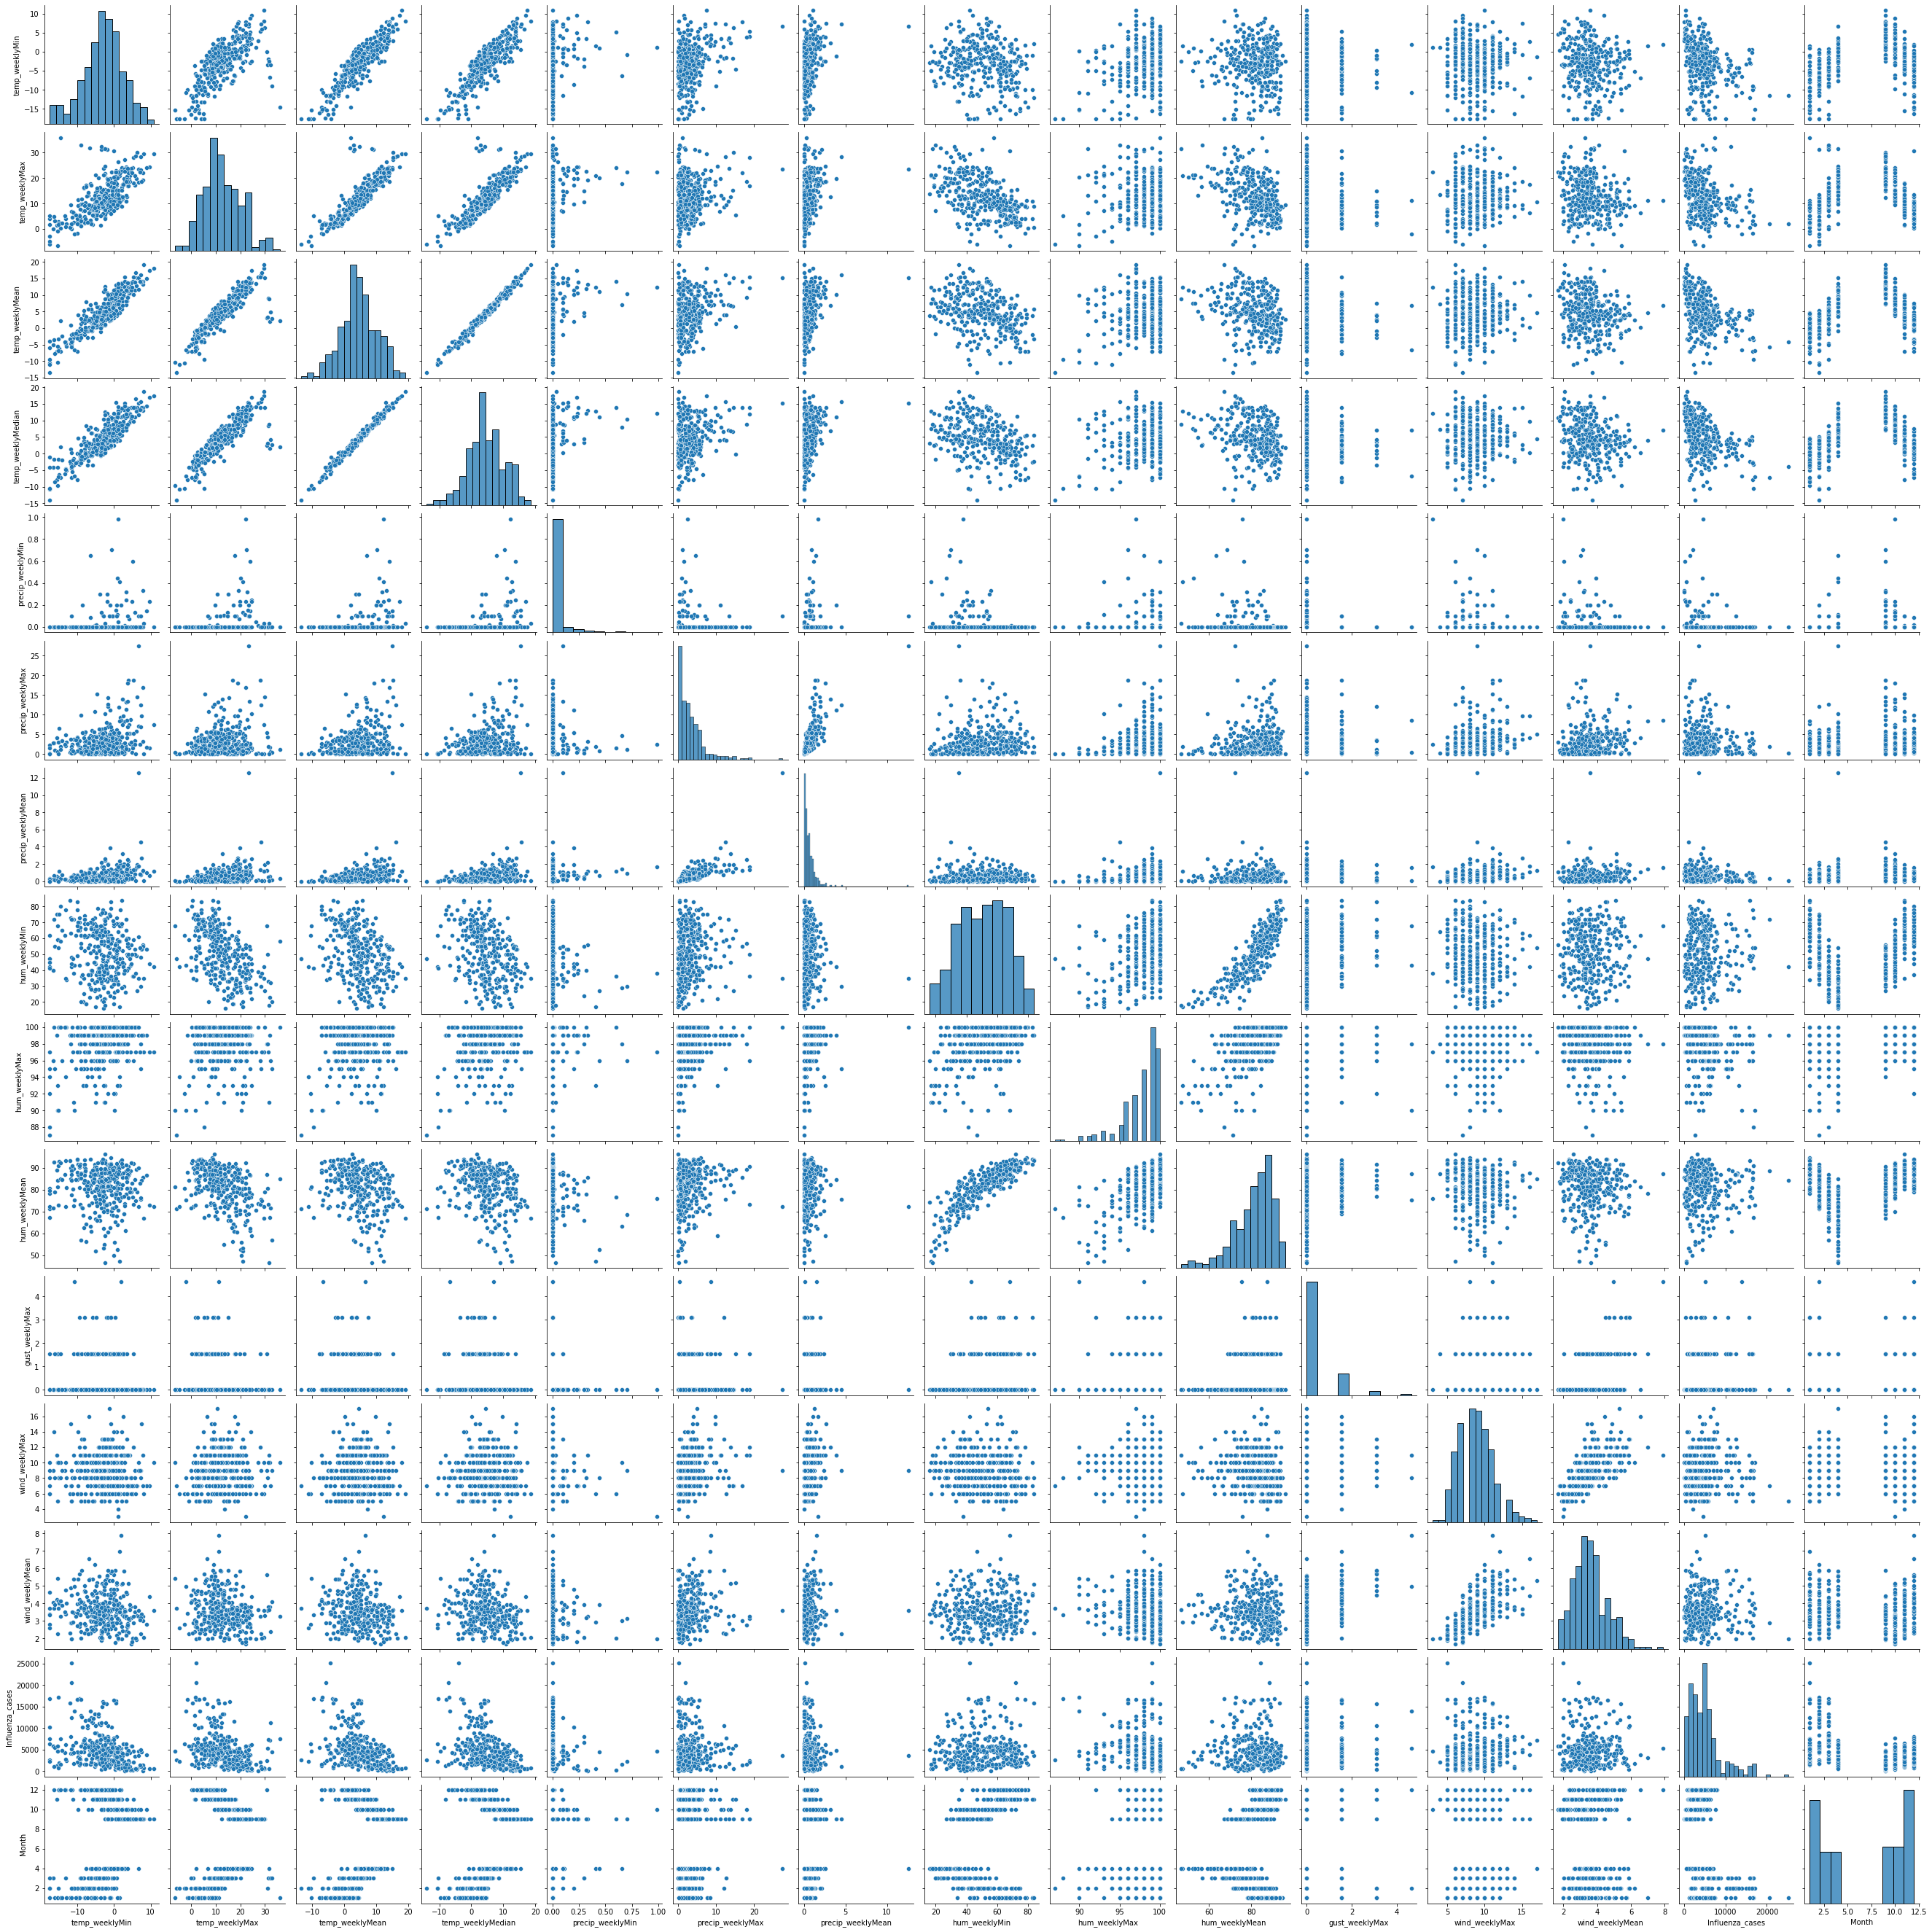

In [41]:
sns.pairplot(data_merged)
plt.show()

# Processed and merged data

import pickle

with open("data/data_merged.pickle","rb") as fp:
    data_merged = pickle.load(fp)


# Visualization

In [44]:
# YOUR CODE HERE
#aise NotImplementedError()
print(data_merged.shape)
#missing_values_table(data_merged)
data_merged.info()


(336, 15)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 336 entries, (2010, 37) to (2020, 52)
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp_weeklyMin     336 non-null    float64
 1   temp_weeklyMax     336 non-null    float64
 2   temp_weeklyMean    336 non-null    float64
 3   temp_weeklyMedian  336 non-null    float64
 4   precip_weeklyMin   336 non-null    float64
 5   precip_weeklyMax   336 non-null    float64
 6   precip_weeklyMean  336 non-null    float64
 7   hum_weeklyMin      336 non-null    float64
 8   hum_weeklyMax      336 non-null    float64
 9   hum_weeklyMean     336 non-null    float64
 10  gust_weeklyMax     336 non-null    float64
 11  wind_weeklyMax     336 non-null    float64
 12  wind_weeklyMean    336 non-null    float64
 13  Influenza_cases    336 non-null    object 
 14  Month              336 non-null    int64  
dtypes: float64(13), int64(1), object(1)
memory usage

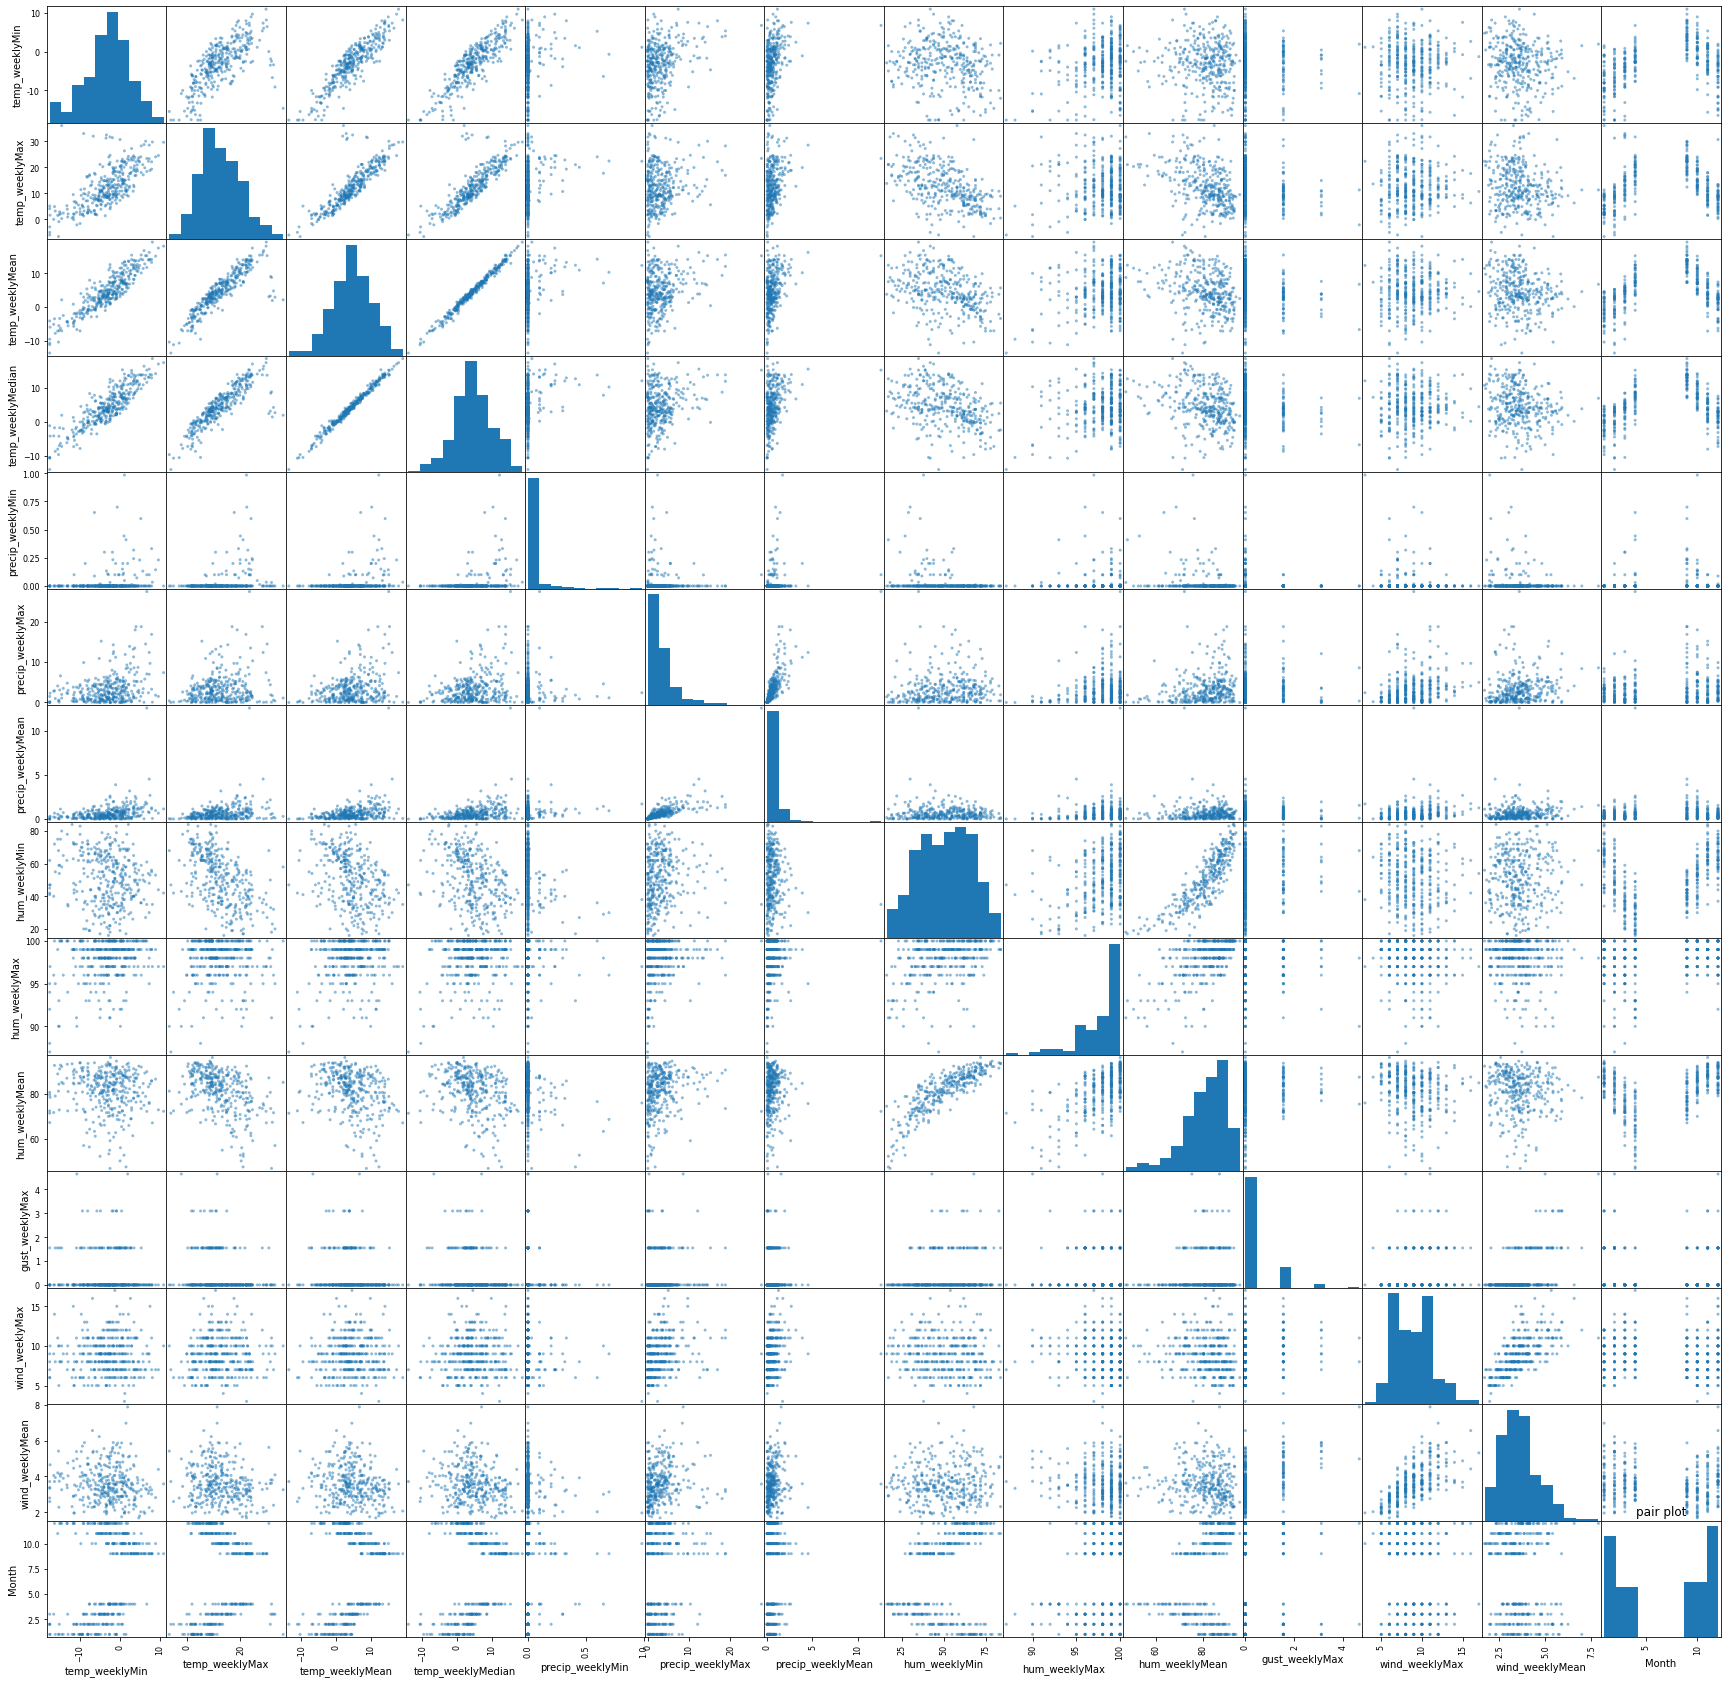

In [47]:
pd.plotting.scatter_matrix(data_merged.drop('Influenza_cases',axis=1), figsize = (30, 30))
plt.title("pair plot")
plt.show()

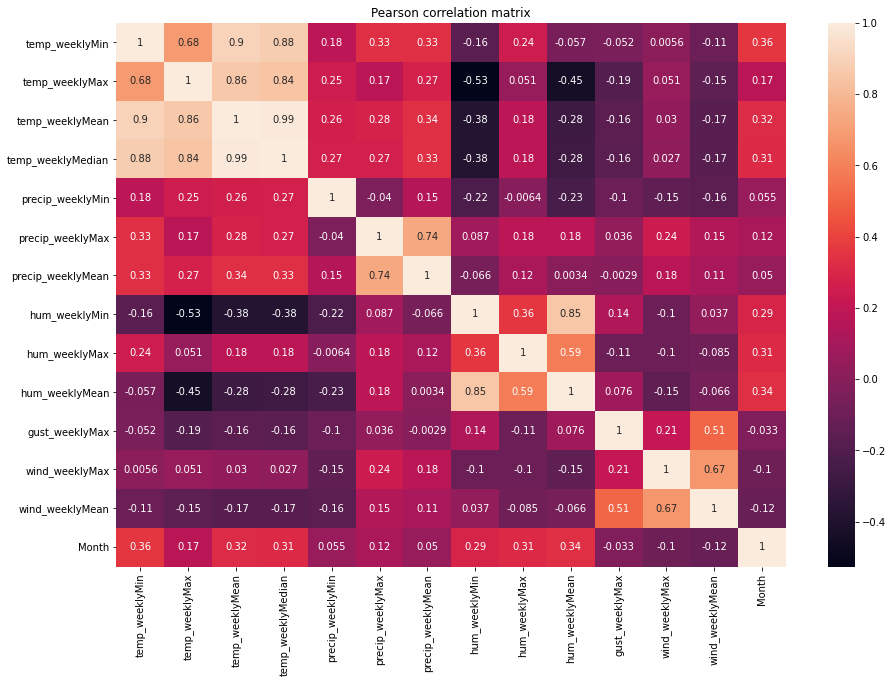

In [48]:
# To find the correlation among the columns using pearson method
corrMatrix = data_merged.corr(method ='pearson')
plt.figure(figsize= (15,10))
sns.heatmap(corrMatrix, annot=True)
plt.title("Pearson correlation matrix")
plt.show()

<Figure size 432x288 with 0 Axes>

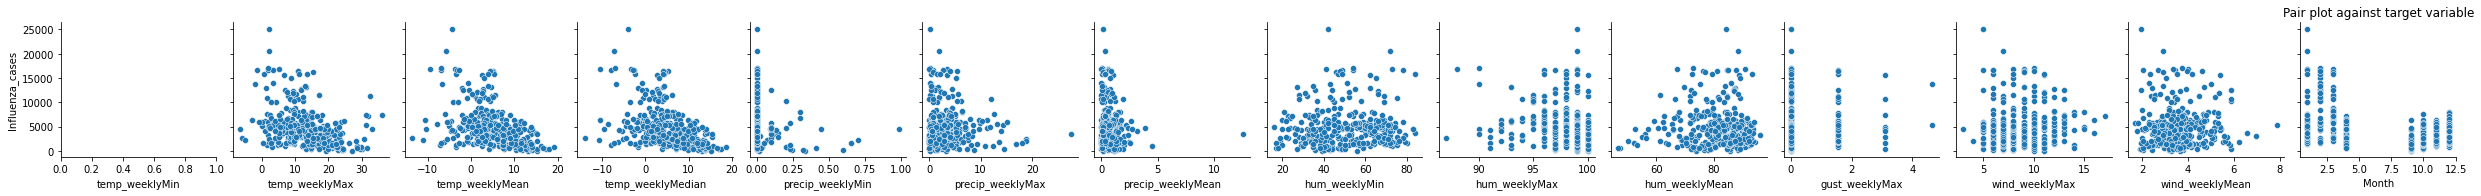

In [49]:
# pair plot against the target variable
plt.figure()
sns.pairplot(data_merged,
                  y_vars=['Influenza_cases'],
                  x_vars= data_merged.drop('Influenza_cases',axis=1).columns)
plt.title('Pair plot against target variable')
plt.show()

# Disease prediction model¶

In [55]:
data_merged.columns

Index(['temp_weeklyMin', 'temp_weeklyMax', 'temp_weeklyMean',
       'temp_weeklyMedian', 'precip_weeklyMin', 'precip_weeklyMax',
       'precip_weeklyMean', 'hum_weeklyMin', 'hum_weeklyMax', 'hum_weeklyMean',
       'gust_weeklyMax', 'wind_weeklyMax', 'wind_weeklyMean',
       'Influenza_cases', 'Month'],
      dtype='object')

In [52]:
class_df = data_merged.drop(['Month'], axis=1)

In [58]:
# Experiment with different features and feature selection methods
#cor = data_merged.corr(method="spearman")
cor = class_df.corr()


In [59]:
class_df_selected = class_df.drop(['temp_weeklyMin','temp_weeklyMax','temp_weeklyMedian', 'hum_weeklyMin','hum_weeklyMax', 'hum_weeklyMean','precip_weeklyMin','precip_weeklyMax','precip_weeklyMean', 'wind_weeklyMean', 'wind_weeklyMax', 'gust_weeklyMax'],axis = 1)
class_df_selected 

temp_weeklyMean Influenza_cases
Year Week                                 
2010 37          13.184545              16
     38          11.856970             125
     39          10.520181             192
     40           7.583929             335
     41           4.240854             342
...                    ...             ...
2020 48           0.234524            4812
     49           2.173494            4105
     50           1.163855            4052
     51           3.320245            2058
     52           2.619312            2938

[336 rows x 2 columns]

In [60]:
# YOUR CODE HERE
#raise NotImplementedError()
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

In [61]:
#predictors = class_df.drop(['Influenza_cases','Month'], axis=1)
predictors = class_df.drop(['Influenza_cases'], axis=1)
target = class_df["Influenza_cases"]

In [62]:
cv_k = 5 #number of cross validation

In [63]:
# step 1: train, validation slplit
xtrain, xtest, ytrain, ytest = train_test_split(predictors, target, test_size=0.2, random_state=50, shuffle = True)

In [64]:
from sklearn.neighbors import KNeighborsRegressor

def regressor_KNN(Xhyper, yhyper, Xt, yt, normalized=False):
    
    if normalized:
        Xhyper = scaler2.fit_transform(Xhyper)
        Xt = scaler2.fit_transform(Xt)
        print("-----------------------------Performance of kNN on normalized dataset----------------------")
    else:
        print("---------------------Performance of kNN on original (not normalized) dataset---------------")
        
    # step 1: find best hyperparameters using gridsearch
    # 1.1 set values of parameters for KNN
    param_grid_search = {"n_neighbors": [1, 2, 4, 6, 8, 10],
                         "weights": ["uniform", "distance"],
                         "algorithm": ["ball_tree", "kd_tree", "brute", "auto"],
                         "p": [1, 2, 5, 10]}

    gsc = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid_search, cv=cv_k)
    grid_result = gsc.fit(Xhyper, yhyper)
    grid_result_df = pd.DataFrame(grid_result.cv_results_)
    #print(grid_result_df)

    # 1.2 make plots of grid search results
    params_to_plot = ['param_n_neighbors', 'param_weights', 'param_algorithm', 'param_p']

    _, axs = plt.subplots(1, 4, figsize=(22, 3))
    axs = axs.flatten()
    for p, ax in zip(params_to_plot, axs):
        ax.plot(grid_result_df.loc[:, [p, "mean_test_score"]].groupby(p).mean(), marker="o")
        ax.set_ylabel("mean cv score")
        ax.set_xlabel(p)
        ax.grid(linestyle="--", alpha=0.5)
    #plt.tight_layout()
    plt.show()
    
    # plot test scores for each hyper parameter combination
    plt.figure(figsize=(16, 4))
    plt.subplot(1,3,1)
    plt.plot(grid_result_df.loc[:, ['mean_test_score']].sum(axis=1).sort_values().values, marker=".",
             linestyle="")
    # plt.ylim(-1.5, 1.5)
    plt.ylabel("mean cv score")
    plt.grid(linestyle="--", alpha=0.5)
    plt.xlabel("parameter combination")
    plt.title("mean cv score for all chosen parameter combination")
    #plt.tight_layout()
    #plt.show()
    
    # run KNN with the best combination of parameters (from gridsearch)
    best_params_KNN = grid_result.best_params_
    print('Best combination:', best_params_KNN)
    best_knn = KNeighborsRegressor(n_neighbors=best_params_KNN["n_neighbors"], algorithm=best_params_KNN["algorithm"],
                                   p=best_params_KNN["p"], weights=best_params_KNN["weights"])

    best_score_knn = cross_val_score(best_knn, Xhyper, yhyper, cv=cv_k)
    # plot cv scores for each iteration for best hyperparameter combination
    plt.subplot(1,3,2)
    i = np.arange(1,cv_k+1,1)
    plt.plot(i,np.sort(best_score_knn), marker="o", linestyle=":", color="red", alpha=.75)
    plt.ylabel("cv score")
    plt.grid(linestyle="--", alpha=0.5)
    plt.xlabel("iteration#")
    plt.xticks(i,i)
    plt.title("cv score for best hyperparameter combination")
    #plt.tight_layout()
    #plt.show()
    
    # plot original vs prediction with best knn
    plt.subplot(1,3,3)
    ypred = cross_val_predict(best_knn, Xhyper, yhyper, cv=cv_k)
    plt.scatter(yhyper, ypred, edgecolors=(0, 0, 0))
    plt.plot([yhyper.min(), yhyper.max()], [yhyper.min(), yhyper.max()], "k--", lw=4)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.title("KNN true vs predicted")
    plt.tight_layout()
    plt.show()
            
    # plot performance on validation dataset
    model = best_knn.fit(Xhyper, yhyper)
    ypred = model.predict(Xt)
    
    return ypred, best_score_knn, model, model.score(Xt,yt)
    

---------------------Performance of kNN on original (not normalized) dataset---------------


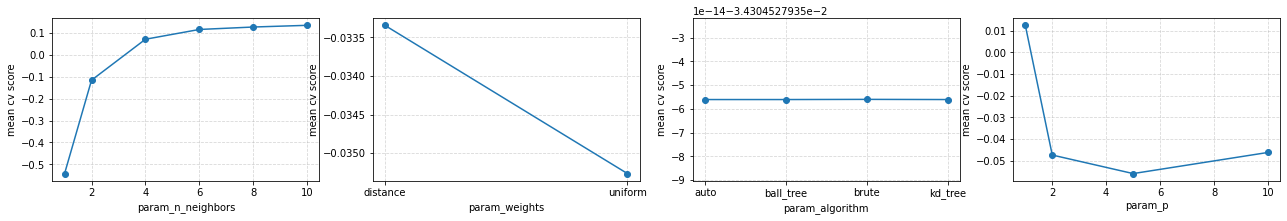

Best combination: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


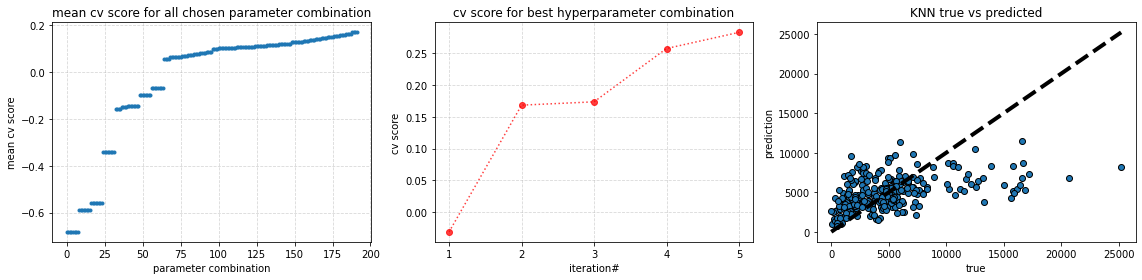

In [65]:
ypred_knn_orig, best_score_knn_orig, model_knn_orig, val_score_knn_orig = regressor_KNN(xtrain, ytrain, xtest, ytest) #original data

-----------------------------Performance of kNN on normalized dataset----------------------


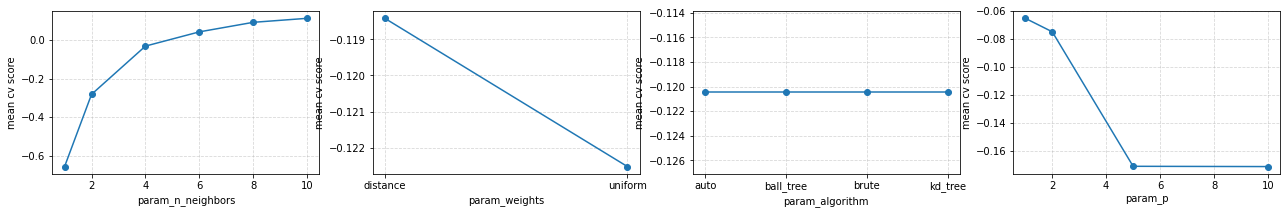

Best combination: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


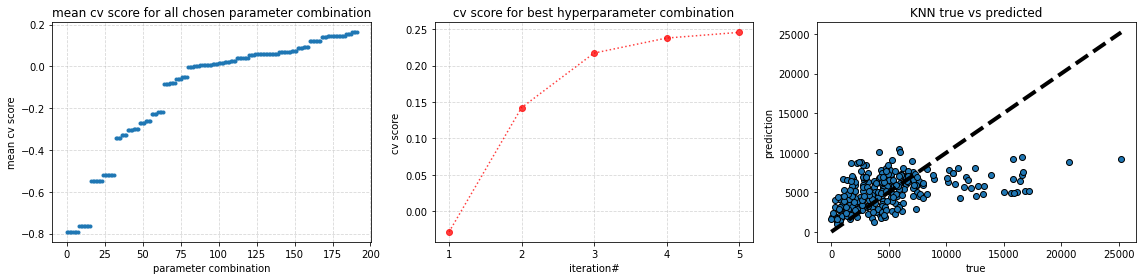

In [66]:
ypred_knn_norm, best_score_knn_norm, model_knn_norm, val_score_knn_norm = regressor_KNN(xtrain, ytrain, xtest, ytest,normalized=True) #normalized data

In [67]:
from sklearn.linear_model import LinearRegression
def regressor_LR(Xhyper, yhyper, Xt, yt, normalized=False):
    
    if normalized: 
        #Xhyper = pd.DataFrame(preprocessing.normalize(Xhyper))
        #Xt = pd.DataFrame(preprocessing.normalize(Xt))
        Xhyper = scaler2.fit_transform(Xhyper)
        Xt = scaler2.fit_transform(Xt)
        #yhyper = scaler2.fit_transform(np.array(yhyper).reshape(-1, 1))
        #yt = scaler2.fit_transform(np.array(yt).reshape(-1, 1))
        # xtest = xtest_norm
        print("--------Performance of Linear Regression on normalized dataset----------")
    else:
        print("--Performance of Linear Regression on original (not normalized) dataset--")
    # step 1: find best hyperparameters using gridsearch
    # 1.1 set values of parameters for LR
    param_grid_search = {'fit_intercept':[True,False], 
                         'copy_X':[True, False]}
    gsc = GridSearchCV(LinearRegression(),
                       param_grid=param_grid_search, cv=cv_k)
    grid_result = gsc.fit(Xhyper, yhyper)
    grid_result_df = pd.DataFrame(grid_result.cv_results_)
    
    # 1.2 make plots of grid search results
    params_to_plot = ['param_fit_intercept', 'param_copy_X']

    _, axs = plt.subplots(1, 2, figsize=(22, 5))
    axs = axs.flatten()
    for p, ax in zip(params_to_plot, axs):
        ax.plot(grid_result_df.loc[:, [p, "mean_test_score"]].groupby(p).mean(), marker="o")
        ax.set_ylabel("mean cv score")
        ax.set_xlabel(p)
        ax.grid(linestyle="--", alpha=0.5)
    #plt.tight_layout()
    plt.show()
    
    # plot test scores for each hyper parameter combination
    plt.figure(figsize=(16, 4))
    plt.subplot(1,3,1)
    plt.plot(grid_result_df.loc[:, ['mean_test_score']].sum(axis=1).sort_values().values, marker=".",
             linestyle="")
    # plt.ylim(-1.5, 1.5)
    plt.ylabel("mean cv score")
    plt.grid(linestyle="--", alpha=0.5)
    plt.xlabel("parameter combination")
    plt.title("mean cv score for all chosen parameter combination")
    #plt.tight_layout()
    #plt.show()
    
    # run RF with the best combination of parameters (from gridsearch)
    best_params_LR = grid_result.best_params_
    print('Best combination:', best_params_LR)
    best_LR = LinearRegression(copy_X = best_params_LR["copy_X"],
                                      fit_intercept = best_params_LR["fit_intercept"])
    
    #plt.figure(figsize=(7,3))
    best_score_LR = cross_val_score(best_LR, Xhyper, yhyper, cv=cv_k)
    # plot cv scores for each iteration for best hyperparameter combination
    plt.subplot(1,3,2)
    i = np.arange(1,cv_k+1,1)
    plt.plot(i,np.sort(best_score_LR), marker="o", linestyle=":", color="red", alpha=.75)
    plt.ylabel("cv score")
    plt.grid(linestyle="--", alpha=0.5)
    plt.xlabel("iteration#")
    plt.xticks(i,i)
    plt.title("cv score")
    
    # plot original vs prediction with best RF
    plt.subplot(1,3,3)
    ypred = cross_val_predict(best_LR, Xhyper, yhyper, cv=cv_k)
    plt.scatter(yhyper, ypred, edgecolors=(0, 0, 0))
    plt.plot([yhyper.min(), yhyper.max()], [yhyper.min(), yhyper.max()], "k--", lw=4)
    plt.xlabel('true')
    plt.ylabel('prediction')
    plt.title("LR true vs predicted")
    plt.tight_layout()
    plt.show()
    
    # plot performance on validation dataset
    model = best_LR.fit(Xhyper, yhyper)
    ypred = model.predict(Xt)
    
    return ypred, best_score_LR, model, model.score(Xt,yt)
    

--Performance of Linear Regression on original (not normalized) dataset--


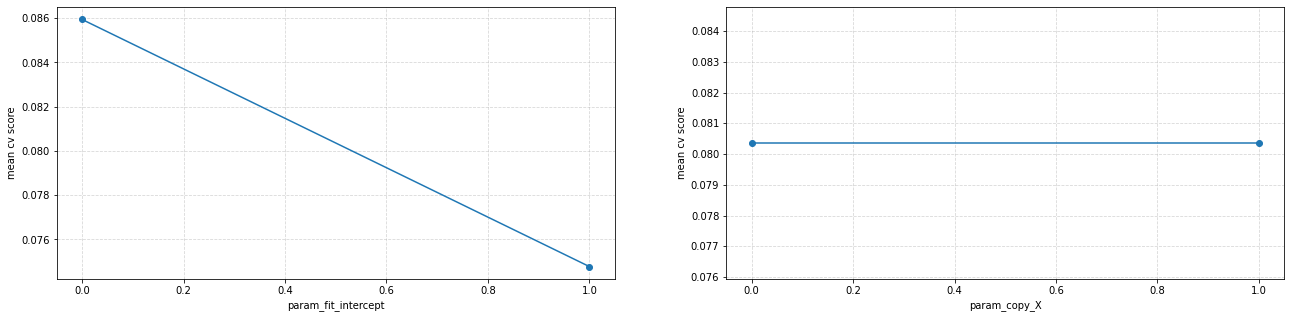

Best combination: {'copy_X': True, 'fit_intercept': False}


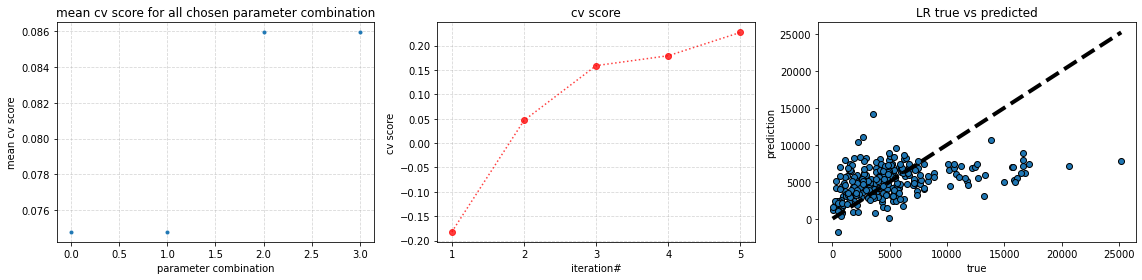

In [68]:
ypred_LR_orig, best_score_LR_orig, model_LR_orig, val_score_LR_orig = regressor_LR(xtrain, ytrain, xtest, ytest) #original data

--------Performance of Linear Regression on normalized dataset----------


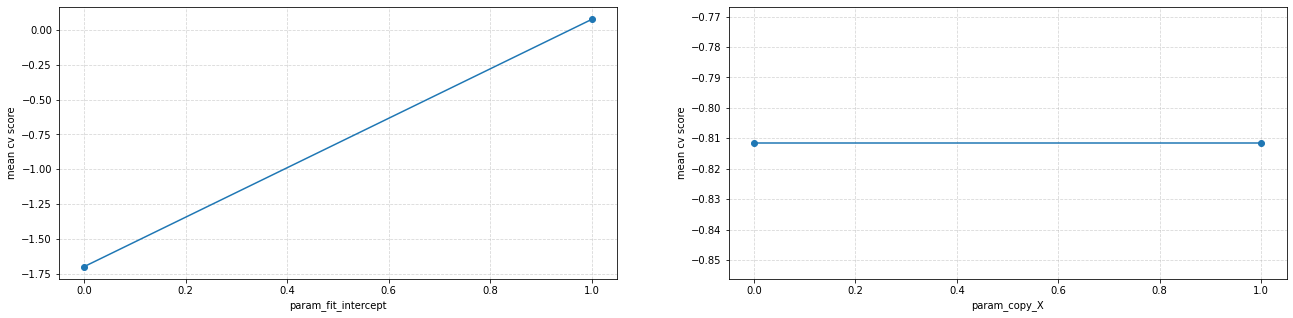

Best combination: {'copy_X': True, 'fit_intercept': True}


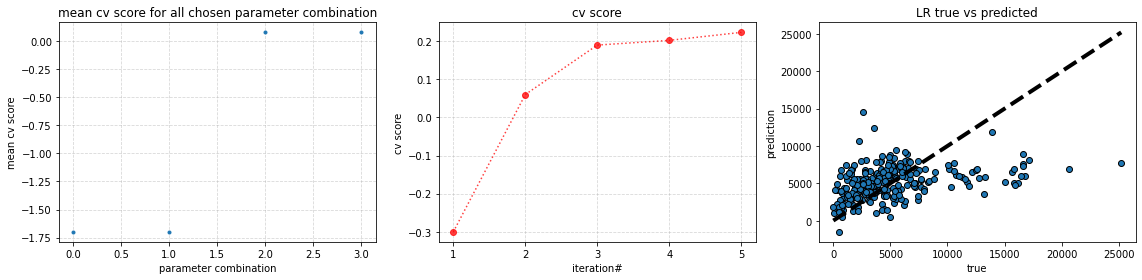

In [69]:
ypred_LR_norm, best_score_LR_norm,model_LR_norm, val_score_LR_norm = regressor_LR(xtrain, ytrain, xtest, ytest, normalized=True) #normalized data

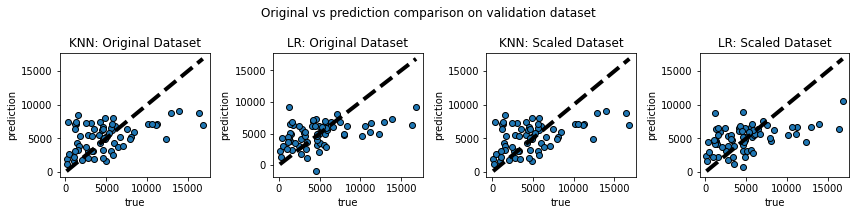

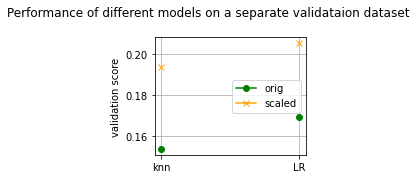

In [70]:
# plot original vs prediction with best RF
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.scatter(ytest, ypred_knn_norm, edgecolors=(0, 0, 0))
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k--", lw=4)
plt.xlabel('true')
plt.ylabel('prediction')
plt.title("KNN: Original Dataset")
plt.subplot(1,4,2)
plt.scatter(ytest, ypred_LR_orig, edgecolors=(0, 0, 0))
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k--", lw=4)
plt.xlabel('true')
plt.ylabel('prediction')
plt.title("LR: Original Dataset")
plt.subplot(1,4,3)
plt.scatter(ytest, ypred_knn_norm, edgecolors=(0, 0, 0))
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k--", lw=4)
plt.xlabel('true')
plt.ylabel('prediction')
plt.title("KNN: Scaled Dataset")
plt.subplot(1,4,4)
plt.scatter(ytest, ypred_LR_norm, edgecolors=(0, 0, 0))
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], "k--", lw=4)
plt.xlabel('true')
plt.ylabel('prediction')
plt.title("LR: Scaled Dataset")
plt.suptitle('Original vs prediction comparison on validation dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize =(3,2.5))
plt.plot(0, val_score_knn_orig, marker = 'o' ,color = 'green', label = 'orig')
plt.plot(0, val_score_knn_norm, marker = 'x',color = 'orange', label = 'scaled')
plt.plot(1, val_score_LR_orig, marker = 'o',color = 'green')
plt.plot(1, val_score_LR_norm, marker = 'x',color = 'orange')
plt.grid()
plt.legend(loc = 'best')
plt.xticks([0,1],['knn','LR'])
plt.ylabel('validation score')
plt.suptitle('Performance of different models on a separate validataion dataset')
plt.tight_layout()
plt.show()

# Test model on last weeks of 2020/2021 season

def load_prediction_data():
    """ 
    Load all weather data files and combi
    ne them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    prediction data
    : data frame containing the weather data
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    #return weather_data
    dir_prediction = r'data/prediction'
    weather_data_files = []
    for file in os.listdir(dir_prediction):
        path = os.path.join(dir_prediction,file)
        data = pd.read_csv(path,encoding= 'unicode_escape', header = None)
        weather_data_files.append(data)
    df = pd.concat(weather_data_files)
    #df.columns = pd.read_csv('data/weather/names.txt',header = None)

    col_names = pd.read_csv('data/weather/names.txt',low_memory=False,header = None).squeeze()

    df.columns = col_names
    
    date = []
    week = []

    for y,m,d,h in zip(df['Year'],df['Month'],df['Day'],df['Hour']):
        n = pd.Timestamp(year=y, month=m, day=d, hour=h)
        date.append(n)
        week.append(n.weekofyear)
    
    # create data and week column
    df['Date'] = pd.Series(date) 
    df['Week'] = pd.Series(week) 
    

    df.set_index(['Year', 'Month','Week','Day', 'Hour'],inplace = True)

    df = df[df['Station code']==int(data_weather['Station code'].unique())]
    

    return df

#loading prediction data
data_prediction = load_prediction_data()

data_prediction

# handling missing values
data_prediction_complete = handle_missingValues_advanced(data_prediction)
# removing outliers based on air temperature
data_prediction_cleaned = handle_outliers(data_prediction_complete)
data_prediction_cleaned

# handling missing values
data_prediction_complete = handle_missingValues_advanced(data_prediction)
# removing outliers based on air temperature
data_prediction_cleaned = handle_outliers(data_prediction_complete)
# aggregating weekly data
data_prediction_weekly = aggregate_weekly(data_prediction_cleaned)
data_prediction_weekly

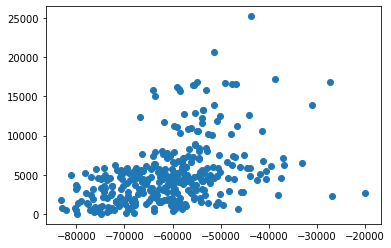

In [75]:
# prediction using the created model in task 7
orig1 = model_LR_norm.predict(predictors)
plt.scatter(orig1,target)

# prediction using the created model 
prediction = model_LR_norm.predict(data_prediction_weekly)
prediction

# Findings

Finding1: The original weather dataset had 96432 rows 104 columns. After handling the missing data and outliers, the dataset shrunk to 95119 rows and 83 columns. Misssing data were filled using interpolation techniques which ultimately lead to reduction of both rows and columns whereas removing outliers didn't change the number of columns but only rows.

Finding2: Out of the 104 weather dataset features, only 13 features were actually relevant to predict the cases of influenza. None of the 13 features had linear relationship with the target varible and also most of those varible showed very little to no correlation with each other (concluded from the pair plot and low values in the off diagonal elemnts in the cross correlation matrix). Only temperature variables showed high correlation with each other.

Finding 3: None of the chosen models( knn and linear regression) performed well on the data_merged dataset (shown by low r2 scores). Out of the two, linear regression performed slightly better. Also standarization of the dataset, resulted in better r2 score.

The classical machine learning methods doesn't seem to fit this data so well. May be deep learning methods can be used to model the data.

